# Segmentation with UNet and FastAI

## Setup

In [1]:
import cv2
import random
import seaborn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from skimage import io, color
from fastai.vision.all import *
from albumentations.pytorch import ToTensorV2

random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 500

real_path = '/home/mathias/Documents/experts_in_teams_proj/vision/data/fence_data/train_set'
synth_path = '/home/mathias/Documents/experts_in_teams_proj/vision/create_fence/data/mask_fence'
test_path = '/home/mathias/Documents/experts_in_teams_proj/vision/data/fence_data/test_set'

In [2]:
class FenceDataset(torch.utils.data.Dataset):
    def __init__(self, root:str, mode:str='train', transforms=None, img_jpg:bool=False)->None:
        assert mode in ['train', 'val', 'test'], f'Unknown mode, got {mode}.'
        
        self.root = root
        self.mode = mode
        self.transforms = transforms
        self.images = list()
        self.labels = list()
        self.classes = ('background', 'fence')
        self.n_classes = len(self.classes)
        if mode == 'train':
            files = open(f'{root}/train.txt', 'rt').read().split('\n')[:-1]
            self.images.extend([f'{root}/images/{f}' for f in files])
            self.labels.extend([f'{root}/labels/{f}' for f in files])
            if img_jpg == True: 
                self.labels = [f.replace('.jpg', '.png') for f in self.labels]

        elif mode == 'val':
            files = open(f'{root}/val.txt', 'rt').read().split('\n')[:-1]
            self.images.extend([f'{root}/images/{f}' for f in files])
            self.labels.extend([f'{root}/labels/{f}' for f in files])  
            if img_jpg == True: 
                self.labels = [f.replace('.jpg', '.png') for f in self.labels]

        elif mode == 'test':
            img_files = os.path.join(root, 'images')
            imgs = [os.path.join(img_files, f) for f in os.listdir(img_files)]
            self.images = sorted(imgs)
            mask_files = os.path.join(root, 'labels')
            masks = [os.path.join(mask_files, f) for f in os.listdir(mask_files)]
            self.labels = sorted(masks)

    def __len__(self): return len(self.images)
    
    def  __getitem__(self, index):
        img = cv2.imread(self.images[index], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.labels[index], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask != 0, 1, 0)

        if self.transforms is not None:
            aug = self.transforms(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        return img, mask.long()
    
    
def get_transforms(train:bool=False, im_size:int=256):
    if train:
        transforms = A.Compose([
            A.OneOf([
                A.RandomSizedCrop(min_max_height=(720, 1536), height=im_size, width=im_size, p=0.5),
                A.Resize(height=im_size, width=im_size, interpolation=cv2.INTER_CUBIC, p=0.5)
            ], p=1), 
            A.ChannelShuffle(),
            A.ShiftScaleRotate(),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomRotate90(),
            A.ColorJitter(),
            A.Blur(),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        transforms = A.Compose([
            A.Resize(height=im_size, width=im_size, interpolation=cv2.INTER_CUBIC),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    return transforms


def one2three(one_channel:np.array)->np.array:
    img = np.zeros((one_channel.shape[0], one_channel.shape[1], 3), one_channel.dtype)
    img[:, :, 0] = one_channel
    img[:, :, 1] = one_channel
    img[:, :, 2] = one_channel
    return img


def display_image_grid(images, true_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i in range(rows):
        img = images[i]
        img = torchvision.transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )(img)
        img = torchvision.transforms.ToPILImage()(img)
        img = np.array(img)

        mask = masks[i]
        mask = mask.to(dtype=torch.int32)
        mask = torchvision.transforms.ToPILImage()(mask)
        mask = one2three(np.array(mask)*255)
        
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            
            predicted_mask = predicted_mask.to(dtype=torch.int32)
            predicted_mask = torchvision.transforms.ToPILImage()(predicted_mask)
            predicted_mask = one2three(np.array(predicted_mask)*255)
            
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    
    plt.tight_layout()
    plt.show()

## Create dataset

In [3]:
# synth_data = FenceDataset(root=synth_path, mode='train', transforms=get_transforms(train=True))
# images, masks = list(), list()
# for i in range(4):
#     img, mask = random.choice(synth_data)
#     images.append(img)
#     masks.append(mask)
# display_image_grid(images, masks)

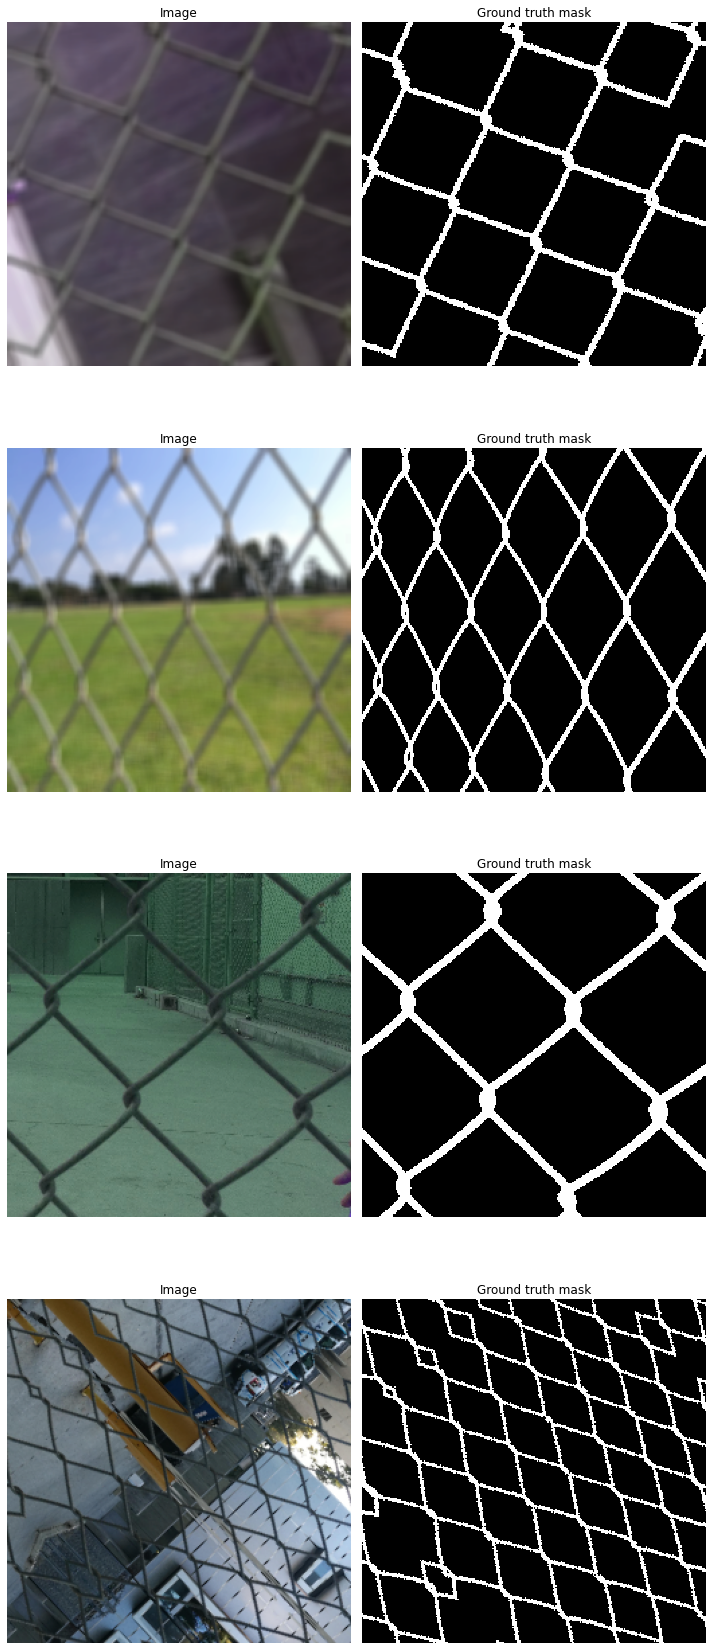

In [4]:
real_data = FenceDataset(root=real_path, mode='train', transforms=get_transforms(train=True), img_jpg=True)
images, masks = list(), list()
for i in range(4):
    img, mask = random.choice(real_data)
    images.append(img)
    masks.append(mask)
display_image_grid(images, masks)

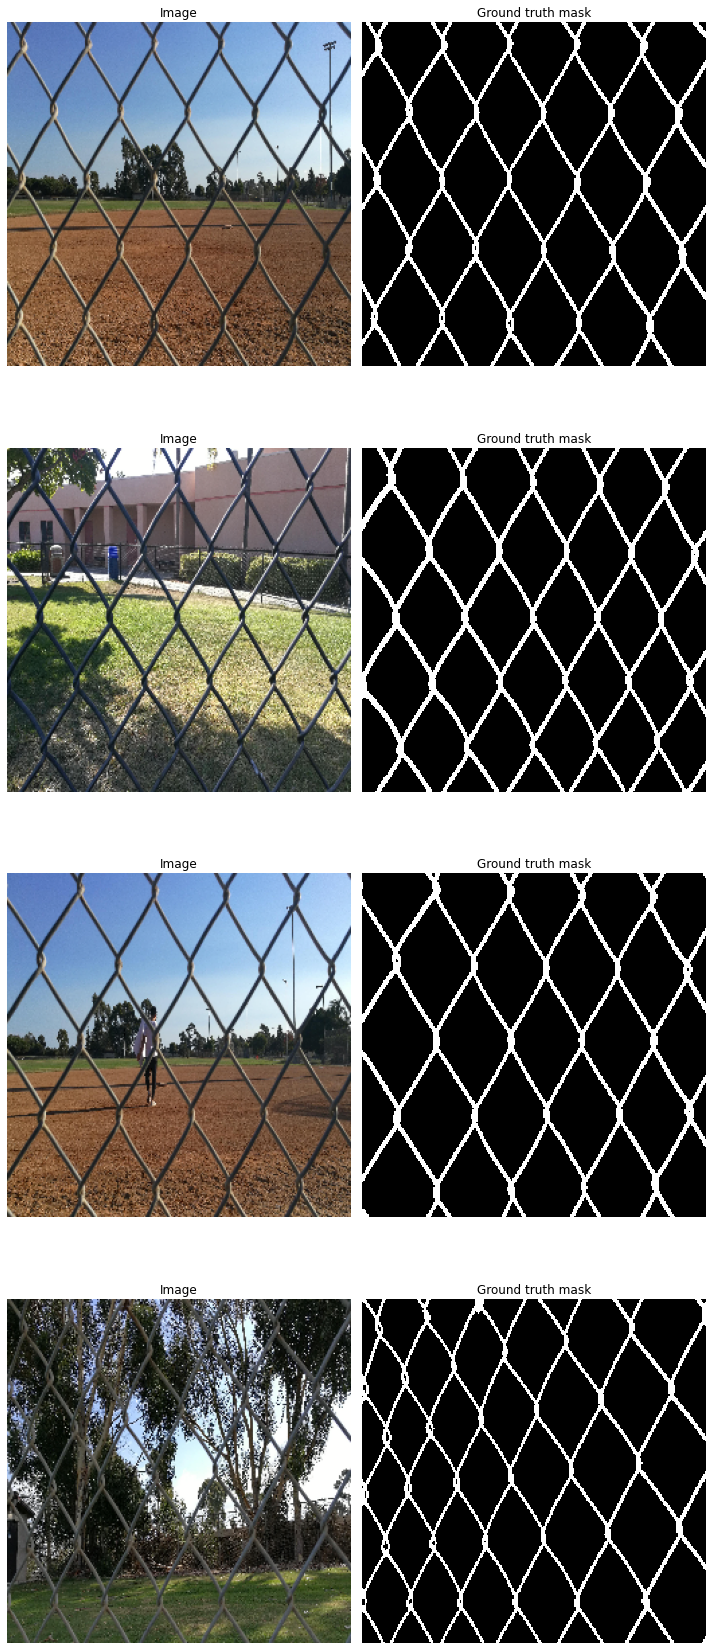

In [5]:
val_data = FenceDataset(root=real_path, mode='val', transforms=get_transforms(train=False), img_jpg=True)
images, masks = list(), list()
for i in range(4):
    img, mask = random.choice(val_data)
    images.append(img)
    masks.append(mask)
display_image_grid(images, masks)

In [6]:
# train_data = torch.utils.data.ConcatDataset([synth_data, real_data])
print(f'Real data: {len(real_data)}. Validation data: {len(val_data)}')
dls = DataLoaders.from_dsets(real_data, val_data, bs=4, device=device)
dls.c = val_data.n_classes

Real data: 381. Validation data: 164


## Train

In [7]:
learner = unet_learner(
    dls=dls,
    arch=torchvision.models.resnet34,
    loss_func=torch.nn.CrossEntropyLoss(),
    metrics=[foreground_acc]
)

learner.fit_one_cycle(
    n_epoch=epochs,
    lr_max=3e-3,
    cbs=[SaveModelCallback(monitor='valid_loss', comp=np.less)]
)

loss, acc = learner.validate()
print(f'Model got: {loss:.4f} loss and {acc:.4f} accuracy.')

epoch,train_loss,valid_loss,foreground_acc,time
0,0.259471,0.205494,0.443123,00:50
1,0.195871,0.166322,0.567114,00:45
2,0.175039,0.143041,0.662522,00:45
3,0.159347,0.137858,0.684374,00:46
4,0.146531,0.154216,0.558884,00:45
5,0.138854,0.122226,0.836740,00:45
6,0.136007,0.123605,0.817909,00:45
7,0.134681,0.114970,0.743193,00:46
8,0.133298,0.126006,0.718662,00:46
9,0.132295,0.117848,0.750799,00:46


Better model found at epoch 0 with valid_loss value: 0.2054940015077591.
Better model found at epoch 1 with valid_loss value: 0.1663217395544052.
Better model found at epoch 2 with valid_loss value: 0.1430407017469406.
Better model found at epoch 3 with valid_loss value: 0.13785842061042786.
Better model found at epoch 5 with valid_loss value: 0.12222601473331451.
Better model found at epoch 7 with valid_loss value: 0.11496981233358383.
Better model found at epoch 10 with valid_loss value: 0.11404306441545486.
Better model found at epoch 12 with valid_loss value: 0.11119268834590912.
Better model found at epoch 13 with valid_loss value: 0.09876400232315063.
Better model found at epoch 16 with valid_loss value: 0.09561126679182053.
Better model found at epoch 18 with valid_loss value: 0.09023061394691467.
Better model found at epoch 26 with valid_loss value: 0.08358601480722427.
Better model found at epoch 28 with valid_loss value: 0.081171415746212.
Better model found at epoch 30 with 

Model got: 0.0406 loss and 0.9332 accuracy.


In [8]:
test_data = FenceDataset(root=test_path, mode='test', transforms=get_transforms(train=False), img_jpg=True)
print(f'Testing data: {len(test_data)}')
dls = DataLoaders.from_dsets(test_data, bs=1, device=device)

pred, true = learner.get_preds(dl=dls)
pred = pred.argmax(dim=1)
acc = (pred.eq(true).sum().float()) / true.nelement()
print(f'Accuracy on test set {acc:.4f}')

Testing data: 100


Accuracy on test set 0.9730


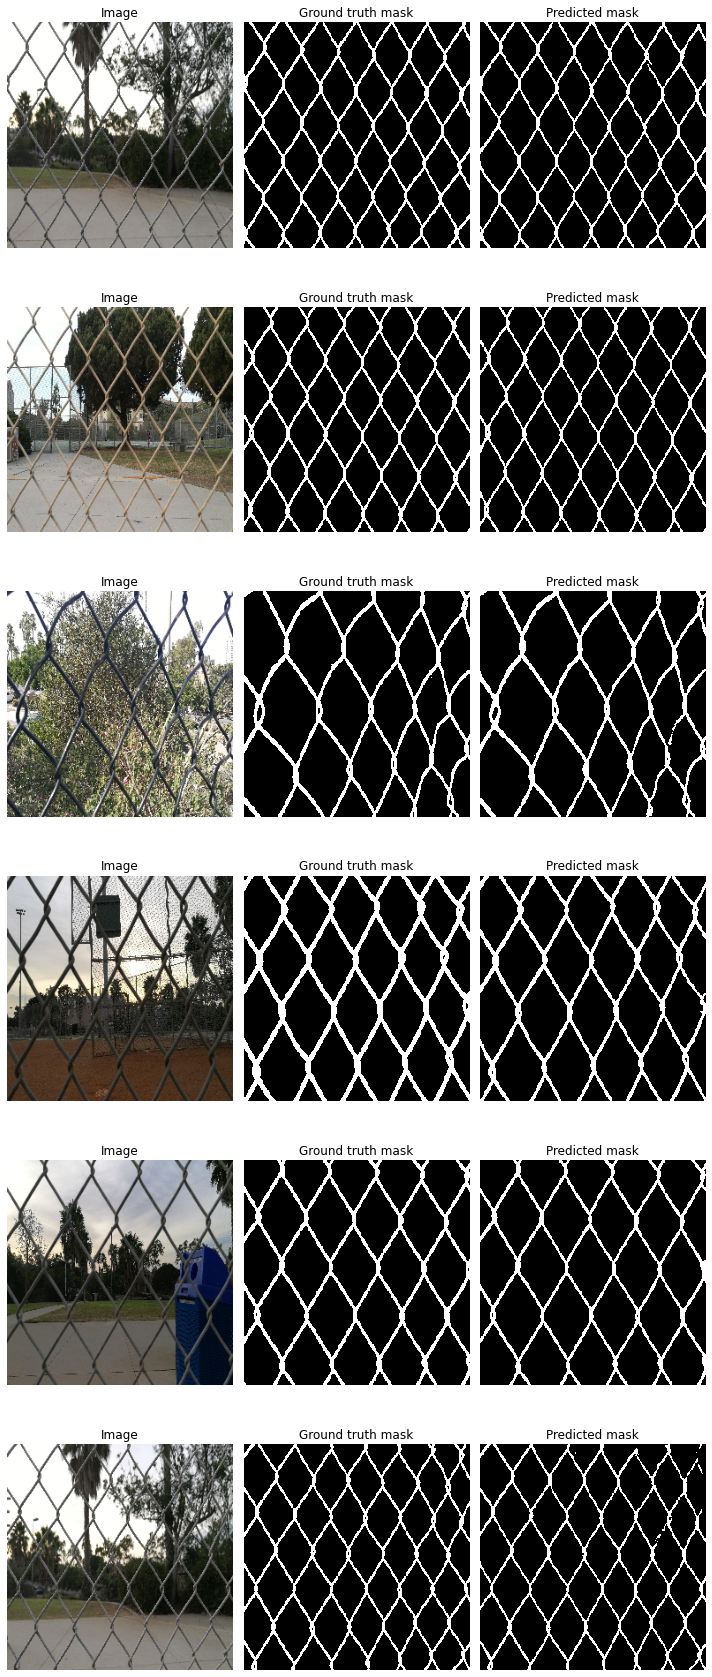

In [9]:
images, masks, pred_masks = list(), list(), list()
for i in range(6):
    idx = random.randint(0, len(test_data))
    img, mask = test_data[idx]
    images.append(img)
    masks.append(mask)
    pred_masks.append(pred[idx])
display_image_grid(images, masks, pred_masks)